In [1]:
import tensorflow as tf
import numpy as np
from bregman.suite import *

In [2]:
filenames = tf.train.match_filenames_once('./audio_dataset/*.wav')
count_num_files = tf.size(filenames)
filename_queue = tf.train.string_input_producer(filenames)
reader = tf.WholeFileReader()
filename, file_contents = reader.read(filename_queue)

In [3]:
chromo = tf.placeholder(tf.float32)
max_freqs = tf.argmax(chromo, 0)

In [20]:
def get_next_chromogram(sess):
    audio_file = sess.run(filename)
    print('Loading {}'.format(audio_file))
    F = Chromagram(str(audio_file, 'utf-8'), nfft=16384, wfft=8192, nhop=2205)
    return F.X

def extract_feature_vector(sess, chromo_data):
    num_features, num_samples = np.shape(chromo_data)
    freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
    hist, bins = np.histogram(freq_vals, bins=range(num_features + 1))
    return hist.astype(float) / num_samples

def get_dataset(sess):
    num_files = sess.run(count_num_files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    xs = []
    for i in range(num_files):
        plt.figure()
        chromo_data = get_next_chromogram(sess)
        plt.subplot(1, 2, 1)
        plt.imshow(chromo_data, cmap='Greys', interpolation='nearest')
        plt.title('Visualization of Sound Spectrum')

        plt.subplot(1, 2, 2)
        freq_vals = sess.run(max_freqs, feed_dict={chromo: chromo_data})
        plt.hist(freq_vals)
        plt.title('Histogram of Notes')
        plt.xlabel('Musical Note')
        plt.ylabel('Count')
        plt.show()
        x = [extract_feature_vector(sess, chromo_data)]
        x = np.matrix(x)
        if len(xs) == 0:
            xs = x
        else:
            xs = np.vstack((xs, x))
        coord.request_stop()
        coord.join(threads)
    return xs

In [5]:
# Listing 5.4 Implementing k-means

k = 2
max_iterations = 100

In [14]:
def initial_cluster_centroids(X, k):
    return X[0:k, :]

def assign_cluster(X, centroids):
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    return mins

def recompute_centroids(X, Y):
    sums = tf.unsorted_segment_sum(X, Y, k)
    counts = tf.unsorted_segment_sum(tf.ones_like(X), Y, k)
    return sums / counts

Loading b'./audio_dataset/cough_2.wav'


/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/bregman/features_base.py:444: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.STFT = P.zeros((self.nfft / 2 + 1, num_frames), dtype='complex')
/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/bregman/features_base.py:384: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mxnorm = P.empty(self._cqtN)  # Normalization coefficients
/Users/yusuke/anaconda/envs/tensorflow/lib/python3.5/site-packages/bregman/features_base.py:390: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  for i in P.arange(self._cqtN)])


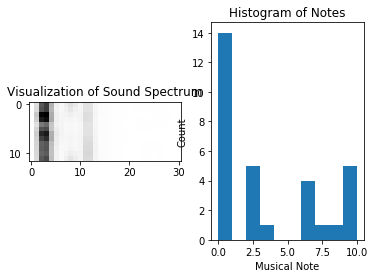

Loading b'./audio_dataset/cough_1.wav'


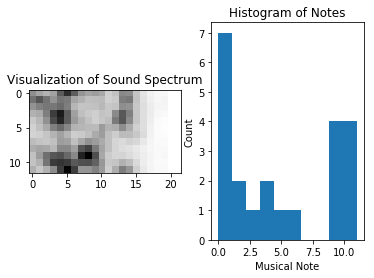

Loading b'./audio_dataset/scream_3.wav'


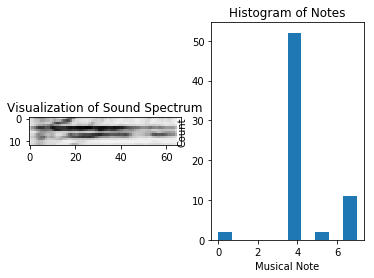

Loading b'./audio_dataset/scream_2.wav'


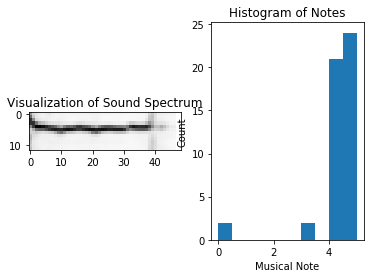

Loading b'./audio_dataset/scream_1.wav'


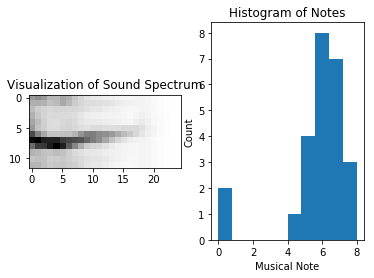

[[ 0.4516129   0.          0.16129032  0.03225806  0.          0.
   0.12903226  0.03225806  0.03225806  0.          0.16129032  0.        ]
 [ 0.06039404  0.05681818  0.02272727  0.02156772  0.33389998  0.1812753
   0.09136364  0.11104478  0.03        0.04545455  0.02272727  0.02272727]]
[[ 0.4516129   0.          0.16129032  0.03225806  0.          0.
   0.12903226  0.03225806  0.03225806  0.          0.16129032  0.        ]
 [ 0.06039404  0.05681818  0.02272727  0.02156772  0.33389998  0.1812753
   0.09136364  0.11104478  0.03        0.04545455  0.02272727  0.02272727]]
[[ 0.4516129   0.          0.16129032  0.03225806  0.          0.
   0.12903226  0.03225806  0.03225806  0.          0.16129032  0.        ]
 [ 0.06039404  0.05681818  0.02272727  0.02156772  0.33389998  0.1812753
   0.09136364  0.11104478  0.03        0.04545455  0.02272727  0.02272727]]
[[ 0.4516129   0.          0.16129032  0.03225806  0.          0.
   0.12903226  0.03225806  0.03225806  0.          0.16129032  0

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X = get_dataset(sess)
    centroids = initial_cluster_centroids(X, k)
    i, converged = 0, False
    while not converged and i < max_iterations:
        i += 1
        Y = assign_cluster(X, centroids)
        centroids = sess.run(recompute_centroids(X, Y))
        print(centroids)